# Import libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split

# Store every image in an array

In [5]:
data_dir = (r'C:\Users\Desktop\Phuse\Training')
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))       

# Resize each image to same size for fast processing

In [6]:
#Resize each Image

img_size = 128
image_array = cv2.resize(img_array, (img_size,img_size))

# Convert each image to grayscale and append into an array

In [7]:
#Convert Image to Grayscale

train_data = []
for i in categories:
    train_path = os.path.join(data_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

# Split the features and target in to X and y

In [8]:
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)

#normalize image pixel value.

X = X/255.0  
X = X.reshape(-1,128,128,1)

(2870, 128, 128)


# One-Hot encode the target column 

In [9]:
#One-Hot encode

from keras.utils.np_utils import to_categorical   

y_enc = to_categorical(y, num_classes = 4)

# Split the data into Train & Test dataset.

In [10]:
X_train , X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)


# Create CNN model

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


epochs = 20


earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience = 3
)


batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)      

# Fit the model with Train and Validation datatsets

In [18]:
imggen.fit(X_train)
history = model.fit_generator(imggen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
145/145 [==============================] - 67s 457ms/step - loss: 1.3273 - accuracy: 0.3643 - val_loss: 1.1206 - val_accuracy: 0.4942
Epoch 2/20
145/145 [==============================] - 67s 461ms/step - loss: 1.0398 - accuracy: 0.5398 - val_loss: 0.7937 - val_accuracy: 0.6409
Epoch 3/20
145/145 [==============================] - 73s 503ms/step - loss: 0.7588 - accuracy: 0.6457 - val_loss: 0.6902 - val_accuracy: 0.6680
Epoch 4/20
145/145 [==============================] - 79s 547ms/step - loss: 0.6832 - accuracy: 0.6996 - val_loss: 0.5664 - val_accuracy: 0.7336
Epoch 5/20
145/145 [==============================] - 80s 550ms/step - loss: 0.5547 - accuracy: 0.7508 - val_loss: 0.5235 - val_accuracy: 0.7915
Epoch 6/20
145/145 [==============================] - 80s 551ms/step - loss: 0.4711 - accuracy: 0.8153 - val_loss: 0.5100 - val_accuracy: 0.7876
Epoch 7/20
145/145 [==============================] - 80s 552ms/step - loss: 0.4712 - accuracy: 0.8109 - val_loss: 0.4331 - val_ac

In [ ]:
model.save("tumor1.h5")

# Plot the Loss vs Epochs graph to visualize loss at each epoch

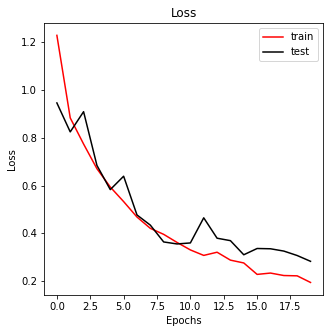

In [13]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["val_loss"],c = "black")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

# Plot Accuracy vs Epoch to visualize accuracy at each epoch

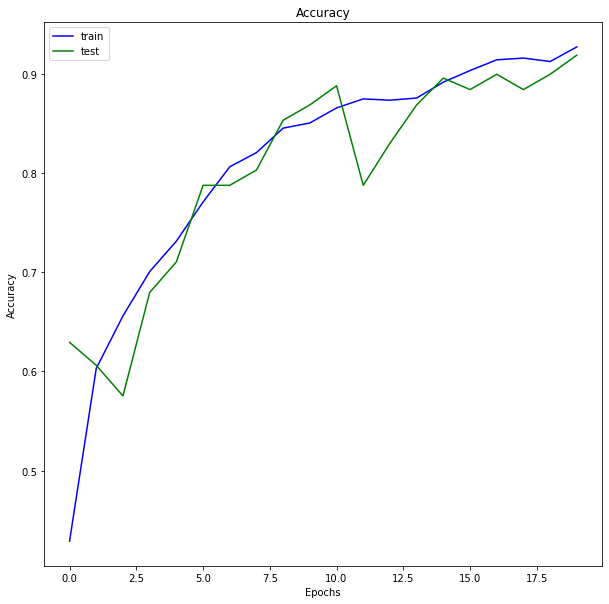

In [14]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.rcParams["figure.figsize"] = (50,50)
plt.legend(["train", "test"])

# Accuracy of Test Dataset

# Testing Accuracy 

In [15]:

score = model.evaluate(X_test, y_test, verbose = 0)
score[1]

0.9163762927055359

# Training Accuracy

In [16]:

score = model.evaluate(X_train, y_train, verbose = 0)
score[1]

0.9750430583953857